# Imports

In [71]:
import pandas as pd
import numpy as np
import shap
shap.initjs()
import warnings
warnings.simplefilter("ignore")
from sklift.datasets import fetch_lenta
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from catboost import CatBoostClassifier

# Loading and preprocessing data 

In [72]:
X, y, t = fetch_lenta(data_home="../data/", return_X_y_t=True)
X.fillna(0)

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,1.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,7.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,0.0000,0.0803
3,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,1.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,2.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687024,35.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,3.0,...,550.09,669.33,111.87,0.00,330.96,1173.84,119.99,2.6458,0.3646,0.3282
687025,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,28.01,0.0000,0.0000,0.0000
687026,36.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.00,0.00,0.00,0.00,0.00,449.01,0.00,0.0000,0.0000,0.0000
687027,37.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.00,46.72,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000


In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687029 entries, 0 to 687028
Columns: 193 entries, age to stdev_discount_depth_1m
dtypes: float64(191), int64(1), object(1)
memory usage: 1011.6+ MB


In [74]:
t = t.apply(lambda x: 1 if x == 'test' else 0)
X.gender = X.gender.apply(lambda x: 1 if x == "М" else 0)

# Building model for adversarial validation

In [75]:
stratification_cols = pd.concat([y, t,], axis=1)

In [76]:
X_train, X_val, treat_train, treat_val = train_test_split(
    pd.concat([X, y], axis=1), t,
    test_size=0.3, 
    random_state=42, 
    stratify=stratification_cols
)

In [77]:
X_train

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,...,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m,response_att
12047,34.0,0.0,2.0,5.0,4.0,0.0,4.0,0.0,5.0,1.0,...,269.82,0.00,528.39,0.00,222.17,690.49,0.0000,NaN,0.2437,0
108928,50.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,6.0,1.0,...,0.00,33.59,0.00,0.00,29.97,134.98,0.0000,0.0000,NaN,0
256288,22.0,0.0,2.0,5.0,0.0,1.0,3.0,0.0,1.0,1.0,...,101.07,111.16,0.00,224.88,393.74,0.00,0.0000,0.0000,0.0000,0
457748,24.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,...,23.99,196.52,256.04,0.00,217.95,197.33,0.0000,NaN,0.3023,0
94821,23.0,0.0,1.0,3.0,2.0,2.0,0.0,1.0,2.0,1.0,...,140.88,505.04,199.88,353.36,39.95,209.45,0.0000,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207604,29.0,1.0,2.0,3.0,2.0,3.0,0.0,0.0,1.0,5.0,...,119.25,160.52,232.57,772.80,316.78,499.57,1.4142,0.0815,0.0815,0
474865,20.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13.49,11.99,0.00,99.25,34.99,0.00,0.0000,0.0000,0.0000,0
626236,28.0,1.0,6.0,3.0,5.0,7.0,6.0,4.0,8.0,9.0,...,381.30,644.56,465.30,892.83,1669.58,133.41,0.0000,0.0000,0.0000,0
657037,60.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,...,30.79,26.99,0.00,0.00,0.00,132.58,0.0000,0.0000,0.0000,0


In [78]:
classifier = CatBoostClassifier(depth=3,
                                random_state=42)

classifier.fit(X_train, treat_train, silent=True)

In [79]:
preds = classifier.predict(X_val)

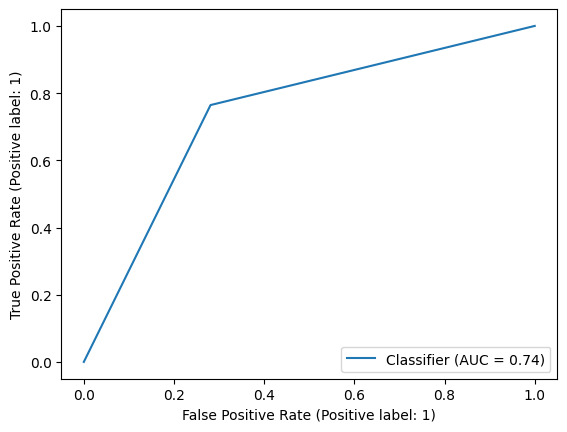

In [80]:
RocCurveDisplay.from_predictions(preds, treat_val)

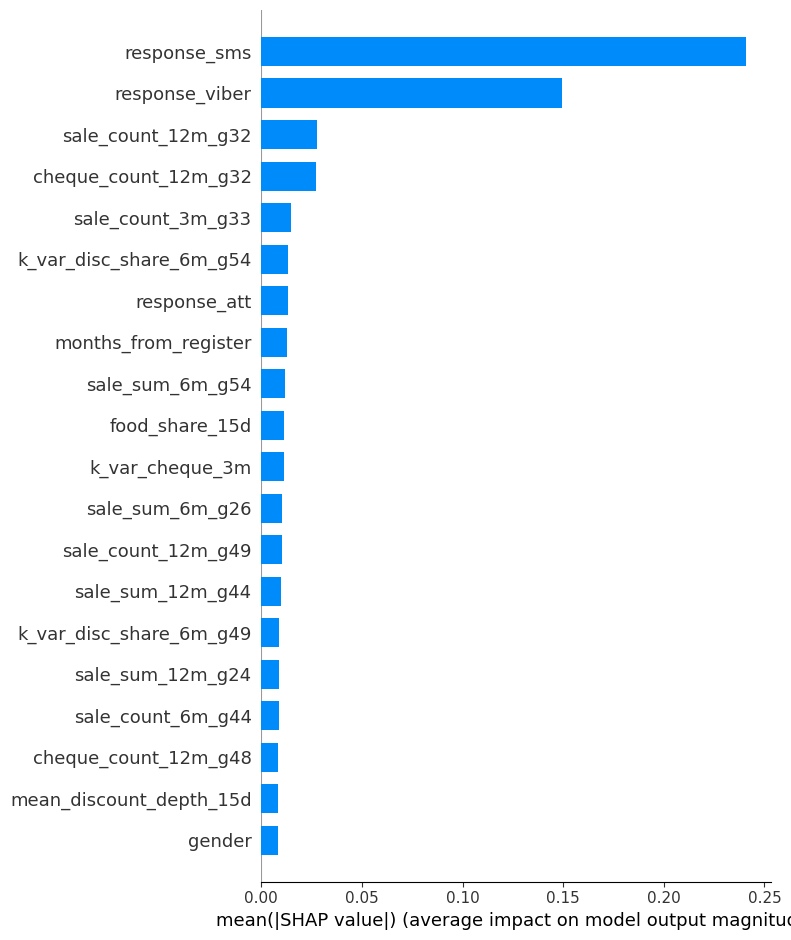

In [81]:
explainer = shap.Explainer(classifier)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Building SoloModel for uplift

In [82]:
class SoloModel:
    def __init__(self, estimator) -> None:
        self.estimator = estimator
        
    def fit(self, X_train, y_train, treatment) -> 'SoloModel':
        X_train = pd.concat([X_train, treatment], axis=1)
        
        self.estimator.fit(X_train, y_train)
        
        return self
    
    def predict_proba(self, X_test) -> np.ndarray:
        pos_t = np.concatenate([X_test.values, np.ones((X_test.shape[0], 1))], axis=1)
        neg_t = np.concatenate([X_test.values, np.zeros((X_test.shape[0], 1))], axis=1)
        
        pos_t_prediction = self.estimator.predict_proba(pos_t)[:, 1]
        neg_t_prediction = self.estimator.predict_proba(neg_t)[:, 1]
        
        uplift = pos_t_prediction - neg_t_prediction
        
        return uplift

In [83]:
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    X,
    t,
    y,
    stratify=stratification_cols,
    test_size=0.3,
    random_state=42
)

In [84]:
uplift_gb = CatBoostClassifier()

solomodel = SoloModel(uplift_gb).fit(X_train, trmnt_train, y_train)

Learning rate set to 0.143939
0:	learn: 0.6526705	total: 79.3ms	remaining: 1m 19s
1:	learn: 0.6238086	total: 154ms	remaining: 1m 16s
2:	learn: 0.6027535	total: 236ms	remaining: 1m 18s
3:	learn: 0.5880820	total: 301ms	remaining: 1m 14s
4:	learn: 0.5772016	total: 378ms	remaining: 1m 15s
5:	learn: 0.5694145	total: 454ms	remaining: 1m 15s
6:	learn: 0.5641358	total: 522ms	remaining: 1m 14s
7:	learn: 0.5604452	total: 588ms	remaining: 1m 12s
8:	learn: 0.5566731	total: 668ms	remaining: 1m 13s
9:	learn: 0.5539661	total: 746ms	remaining: 1m 13s
10:	learn: 0.5525501	total: 805ms	remaining: 1m 12s
11:	learn: 0.5508846	total: 881ms	remaining: 1m 12s
12:	learn: 0.5498270	total: 955ms	remaining: 1m 12s
13:	learn: 0.5490453	total: 1.02s	remaining: 1m 12s
14:	learn: 0.5486359	total: 1.09s	remaining: 1m 11s
15:	learn: 0.5483497	total: 1.15s	remaining: 1m 11s
16:	learn: 0.5477015	total: 1.23s	remaining: 1m 11s
17:	learn: 0.5473501	total: 1.3s	remaining: 1m 10s
18:	learn: 0.5470148	total: 1.38s	remaining:

In [85]:
uplift = solomodel.predict_proba(X_val)

# SHAP values

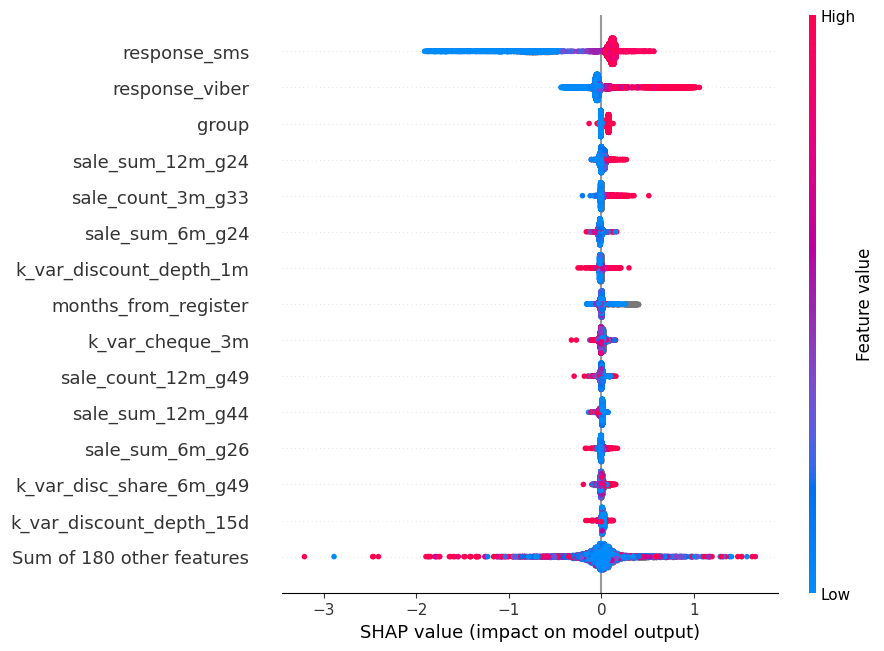

In [86]:
subset = pd.concat([X_train, trmnt_train], axis=1).sample(10000)

explainer = shap.Explainer(solomodel.estimator)
shap_values = explainer(subset)

shap.plots.beeswarm(shap_values, max_display=15)

In [87]:
subset

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,...,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m,group
107868,53.0,0.0,0.0,20.0,3.0,13.0,6.0,2.0,0.0,2.0,...,795.39,34.89,306.06,345.32,78.28,0.00,0.0000,NaN,NaN,1
581028,32.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,80.92,31.58,42.99,0.00,0.00,37.99,0.0000,0.0000,0.0000,1
389520,57.0,1.0,4.0,5.0,1.0,4.0,0.0,0.0,5.0,3.0,...,196.47,143.46,0.00,549.13,551.47,176.48,NaN,0.0000,0.0000,1
662097,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,83.89,0.0000,NaN,NaN,0
11841,NaN,0.0,0.0,1.0,2.0,1.0,0.0,2.0,1.0,0.0,...,13.99,35.58,220.94,179.68,0.00,149.70,1.2910,0.2350,0.2007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511453,53.0,3.0,3.0,4.0,0.0,2.0,4.0,1.0,3.0,2.0,...,75.18,0.00,0.00,342.87,147.26,47.28,0.0000,0.0000,NaN,1
183948,35.0,8.0,4.0,11.0,0.0,7.0,0.0,1.0,7.0,10.0,...,272.75,173.70,0.00,404.78,426.97,421.00,0.0000,NaN,NaN,0
442663,25.0,2.0,7.0,2.0,3.0,10.0,7.0,5.0,3.0,9.0,...,39.99,488.81,683.56,565.24,302.24,144.37,0.0000,NaN,NaN,0
534881,56.0,9.0,13.0,32.0,17.0,25.0,10.0,6.0,26.0,17.0,...,696.65,178.02,962.73,2532.10,1953.44,1140.50,3.5355,0.1794,0.1937,1


In [88]:
def uplift_at_k_split_by_groups(y_val, uplift, trmnt_val, k=0.05):
    y_val, uplift, trmnt_val = np.array(y_val), np.array(uplift), np.array(trmnt_val)
    threshold = int(len(y_val) * k)
    order = np.argsort(uplift)[::-1]
    
    score_ctrl = y_val[order][:threshold][trmnt_val[order][:threshold] == 0].mean()
    score_trmnt = y_val[order][:threshold][trmnt_val[order][:threshold] == 1].mean()
    
    return score_trmnt - score_ctrl

In [89]:
def uplift_at_k_split_overall(y_val, uplift, trmnt_val, k=0.05):
    y_val, uplift, trmnt_val = np.array(y_val), np.array(uplift), np.array(trmnt_val)
    threshold = int(len(y_val) * k)
    order = np.argsort(uplift)[::-1]
    
    score = y_val[order][:threshold].mean()
    
    return score

In [90]:
uplift_at_k_split_by_groups(y_val, uplift, trmnt_val, 0.25)

0.010247113426404247

In [91]:
uplift_at_k_split_overall(y_val, uplift, trmnt_val, 0.25)

0.08191821763347372